<a href="https://colab.research.google.com/github/Francesco0101/Computer-Vision-Project-on-Ground-To-Aerial-Matching/blob/main/CV_project_on_Cross_image_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [ ]:
%%capture
!pip install gdown
!pip install rarfile
!pip install datasets opencv-contrib-python opencv-python ipywidgets scipy
!pip install pytorch_lightning
!pip install pytorch_lightning

In [1]:
import gdown
import zipfile
import os
# from google.colab.patches import cv2_imshow #rimuovere se online
import cv2
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torch.utils.data import random_split
import logging
from collections import OrderedDict
import torchvision
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from torch import optim
from torch.utils.data.distributed import DistributedSampler
from pytorch_lightning.callbacks.progress import RichProgressBar
import matplotlib.pyplot as plt

In [ ]:
torch.set_float32_matmul_precision('medium') # solo in locale

#University Dataset da cambiare

In [ ]:
!wget -O file.zip 'https://drive.google.com/file/d/17W9VEPMneRlb6igtSxa--Xh4fSZs3RS_/view?usp=sharing' #Download dataset


In [ ]:

# Percorso del file zip
file_zip = "dataset.zip"

# Percorso di destinazione per l'estrazione
percorso_estrazione = "/content"

# Estrai il file zip
with zipfile.ZipFile(file_zip, 'r') as zip_ref:
    zip_ref.extractall(percorso_estrazione)

# Mostra i file estratti
print("File estratti in:", percorso_estrazione)
print("Elenco dei file estratti:")
for file in os.listdir(percorso_estrazione):
    print(file)

#CVUSA Dataset

To load directly without drive

In [8]:
"""

!pip install rarfile
!gdown --id 17W9VEPMneRlb6igtSxa--Xh4fSZs3RS_

"""

'\n\n!pip install rarfile\n!gdown --id 17W9VEPMneRlb6igtSxa--Xh4fSZs3RS_\n\n'

In [9]:
# import rarfile
# import os

# # Percorso del file RAR
# file_rar = "/content/drive/MyDrive/CV/CVUSA_subset.rar"

# # Directory di destinazione per l'estrazione
# extract_path = "/content/CVUSA_subset"

# # Estrarre il file RAR
# with rarfile.RarFile(file_rar, 'r') as rar:
#     # Crea la directory di destinazione se non esiste
#     os.makedirs(extract_path, exist_ok=True)
#     # Estrai tutto nella directory di destinazione
#     rar.extractall(extract_path)

# print("Estrazione completata.")

In [10]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [11]:
# Percorsi delle directory
import re
#Francesco
bingmap_dir = '/content/drive/MyDrive/CVUSA/bingmap'
streetview_dir = '/content/drive/MyDrive/CVUSA/streetview'
cvusa_dir = '/content/drive/MyDrive/CVUSA'
#Simone
bingmap_dir = 'CVUSA_subset/bingmap'
streetview_dir = 'CVUSA_subset/streetview'
bingmap_sift_dir = 'CVUSA_subset/sift/bingmap'
streetview_sift_dir = 'CVUSA_subset/sift/streetview'
cvusa_dir = 'CVUSA_subset'
csv_path = 'CVUSA_subset/file_paths.csv'

# Function to extract numeric identifier from filenames
def extract_identifier(filename):
    match = re.search(r'\d+', filename)
    return match.group() if match else None

# Read files from directories
bingmap_files = sorted(os.listdir(bingmap_dir))
streetview_files = sorted(os.listdir(streetview_dir))
bingmap_sift_files = sorted(os.listdir(bingmap_sift_dir))
streetview_sift_files = sorted(os.listdir(streetview_sift_dir))

print(len(bingmap_files))
print(len(streetview_files))
print(len(bingmap_sift_files))
print(len(streetview_sift_files))



# Create dictionaries to map identifiers to filenames
bingmap_dict = {extract_identifier(f): f for f in bingmap_files}
streetview_dict = {extract_identifier(f): f for f in streetview_files}
bingmap_sift_dict = {extract_identifier(f): f for f in bingmap_sift_files}
streetview_sift_dict = {extract_identifier(f): f for f in streetview_sift_files}

# Find all identifiers
all_identifiers = set(bingmap_dict.keys()).union(streetview_dict.keys(), bingmap_sift_dict.keys(), streetview_sift_dict.keys())

# Write file paths to CSV
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    for identifier in all_identifiers:
        bingmap_file = bingmap_dict.get(identifier, "None")
        streetview_file = streetview_dict.get(identifier, "None")
        bingmap_sift_file = bingmap_sift_dict.get(identifier, "None")
        streetview_sift_file = streetview_sift_dict.get(identifier, "None")

        bingmap_path = f"{bingmap_dir}/{bingmap_file}" if bingmap_file != "None" else "None"
        streetview_path = f"{streetview_dir}/{streetview_file}" if streetview_file != "None" else "None"
        bingmap_sift_path = f"{bingmap_sift_dir}/{bingmap_sift_file}" if bingmap_sift_file != "None" else "None"
        streetview_sift_path = f"{streetview_sift_dir}/{streetview_sift_file}" if streetview_sift_file != "None" else "None"

        writer.writerow([bingmap_path, streetview_path, bingmap_sift_path, streetview_sift_path])

print(f"CSV creato con successo in {csv_path}")

8862
8862
8855
8861
CSV creato con successo in CVUSA_subset/file_paths.csv


#SIFT DETECTOR


In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# Definisci le liste per salvare i descrittori
Aerial_sift = []
Ground_sift = []

def extract_sift_descriptor(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()

    keypoints, descriptors = sift.detectAndCompute(image, None)

    if descriptors is not None:
        return descriptors
    else:
        print("No descriptors found.")
        return None

# Esempio di utilizzo per estrarre e salvare i descrittori SIFT

for file in tqdm(bingmap_files):
    if file.endswith(".png"):
        image_path = os.path.join(bingmap_dir, file)
        sift_descriptor = extract_sift_descriptor(image_path)
        if sift_descriptor is not None:
            Aerial_sift.append(sift_descriptor)
            # Salva i descrittori nel file npy
            np.save(f"/sift/bingmap/sift_descriptors_{file[:-4]}.npy", sift_descriptor)
            # print(f"Saved SIFT descriptors for {file}")

# Ora Aerial_sift contiene tutti i descrittori SIFT estratti, e sono stati salvati su disco.


  8%|█████▉                                                                         | 671/8862 [00:27<04:27, 30.67it/s]

No descriptors found.


  9%|███████▍                                                                       | 836/8862 [00:35<04:15, 31.43it/s]

No descriptors found.


 16%|████████████▎                                                                 | 1393/8862 [01:00<04:25, 28.17it/s]

No descriptors found.


 25%|███████████████████▍                                                          | 2210/8862 [01:45<06:26, 17.23it/s]

No descriptors found.


 47%|████████████████████████████████████▊                                         | 4184/8862 [03:27<04:20, 17.99it/s]

No descriptors found.


 50%|██████████████████████████████████████▋                                       | 4399/8862 [03:40<03:30, 21.17it/s]

No descriptors found.


 84%|█████████████████████████████████████████████████████████████████▌            | 7454/8862 [06:51<02:35,  9.05it/s]

No descriptors found.


100%|██████████████████████████████████████████████████████████████████████████████| 8862/8862 [08:58<00:00, 16.47it/s]


In [ ]:
for file in tqdm(streetview_files):
    if file.endswith(".jpg"):
        image_path = os.path.join(streetview_dir, file)
        sift_descriptor = extract_sift_descriptor(image_path)
        if sift_descriptor is not None:
            Aerial_sift.append(sift_descriptor)
            # Salva i descrittori nel file npy
            np.save(f"/sift/streetview/sift_descriptors_{file[:-4]}.npy", sift_descriptor)
            # print(f"Saved SIFT descriptors for {file}")

 75%|██████████████████████████████████████████████████████████▍                   | 6644/8862 [11:15<03:07, 11.84it/s]

No descriptors found.


100%|██████████████████████████████████████████████████████████████████████████████| 8862/8862 [15:26<00:00,  9.56it/s]


In [ ]:
import numpy as np

# Esempio di caricamento di un descriptor SIFT da un file .npy
filename = "/sift/bingmap/sift_descriptors_input0000008.npy"  # Assicurati di specificare il percorso completo se non è nello stesso script

# Carica il descriptor SIFT dal file .npy
sift_descriptor = np.load(filename)

# Ora puoi utilizzare il descriptor SIFT per qualsiasi operazione desideri
print("Shape of loaded descriptor:", sift_descriptor.shape)
print("Example of loaded descriptor:", sift_descriptor[:10])  # Esempio di stampa dei primi 10 elementi del descriptor

Shape of loaded descriptor: (1143, 128)
Example of loaded descriptor: [[ 7.  0.  0. ...  8.  0.  0.]
 [ 0.  0.  0. ... 22.  7. 36.]
 [ 0.  1.  5. ...  0. 18. 76.]
 ...
 [82. 35.  9. ...  3.  5.  0.]
 [ 6. 13.  2. ... 53.  7.  3.]
 [33. 31. 27. ... 28. 78. 51.]]


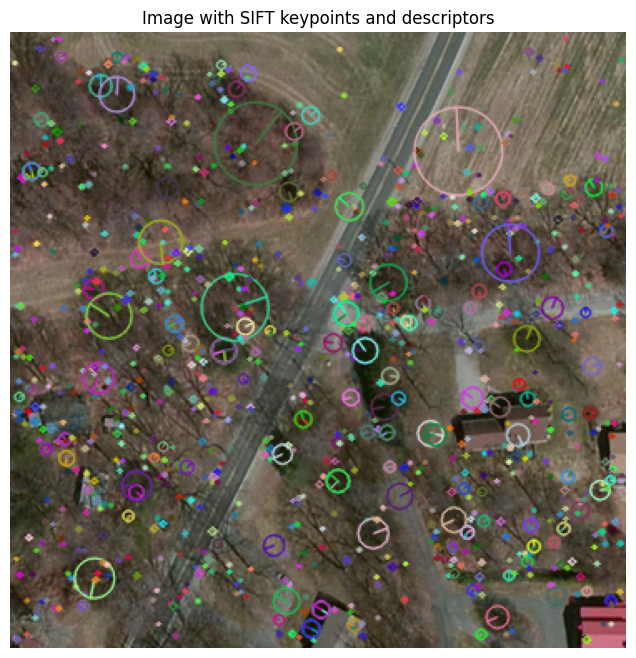

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Funzione per caricare l'immagine con keypoints e descrittori SIFT sovrapposti
def visualize_sift(image_path, sift_descriptor_path):
    # Carica l'immagine originale
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti da BGR (OpenCV) a RGB (Matplotlib)

    # Carica i descrittori SIFT dal file .npy
    sift_descriptor = np.load(sift_descriptor_path)

    # Crea l'oggetto SIFT
    sift = cv2.SIFT_create()

    # Trova keypoints e calcola i descrittori
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Disegna i keypoints e i descrittori SIFT sull'immagine
    image_with_sift = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Visualizza l'immagine con i keypoints e i descrittori sovrapposti
    plt.figure(figsize=(10, 8))
    plt.imshow(image_with_sift)
    plt.title('Image with SIFT keypoints and descriptors')
    plt.axis('off')
    plt.show()

# Esempio di utilizzo
image_path = "/CVUSA_subset/bingmap/input0000008.png"
sift_descriptor_path = "/sift/bingmap/sift_descriptors_input0000008.npy"

visualize_sift(image_path, sift_descriptor_path)


# Dataset

In [12]:
class CVUSADatasetPath(Dataset):
    def __init__(self, cvusa_dir, directory):
        self.directory = directory
        self.cvusa_dir = cvusa_dir
        self.aerial_paths = []
        self.ground_paths = []
        self.aerial_sift_paths = []
        self.ground_sift_paths = []

        with open(self.directory, mode='r') as file:
          csv_reader = csv.reader(file, delimiter=',')
          for row in csv_reader:
              aerial_path = row[0]
              ground_path = row[1]
              aerial_sift_path = row[2]
              ground_sift_path = row[3]
              self.aerial_paths.append(aerial_path)
              self.ground_paths.append(ground_path)
              self.aerial_sift_paths.append(aerial_sift_path)
              self.ground_sift_paths.append(ground_sift_path)



    def __len__(self):
        return len(self.aerial_paths) # any image path is good

    def __getitem__(self, idx):
        return self.ground_paths[idx], self.aerial_paths[idx], self.ground_sift_paths[idx], self.aerial_sift_paths[idx]

In [30]:
class CVUSADataset(pl.LightningDataModule):
    def __init__(self, cvusa_dir, directory, batch_size=32, transform = True):
        super().__init__()
        self.batch_size = batch_size
        self.cvusa_dir = cvusa_dir
        self.directory = directory
        self.transformation = transform

    def setup(self, stage=None):
        self.dataset = CVUSADatasetPath(self.cvusa_dir, self.directory)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(self.dataset, [0.8, 0.1, 0.1])

    def transform(self, set_type):
      transform = None
      if self.transformation == False:
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
      elif set_type == 'train':
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
        ])
      else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
        ])
      return transform

    def load_sift(self, paths):
      sifts = []
      for i in range(len(paths)):
        if paths[i] != "None":
          sift = np.load(paths[i])
        else:
          sift = np.zeros(128)
        sifts.append(sift)
      return sifts



    def load_images(self, paths, set_type):
      images = []
      idx = []
      for i in range(len(paths)):
        img = cv2.imread(paths[i])
        img = Image.fromarray(img)
        img = self.transform(set_type)(img)
        images.append(img)
        idx.append(paths[i])
      return torch.stack(images)

    def collate_fn_train(self, batch):
      return self.collate_fn(batch, 'train')

    def collate_fn_val(self, batch):
      return self.collate_fn(batch, 'val')

    def collate_fn(self, batch, set_type):
      ground_paths, aerial_paths, ground_sift_paths, aerial_sift_paths = zip(*batch)
      ground_images = self.load_images(ground_paths, set_type)
      aerial_images = self.load_images(aerial_paths, set_type)
      ground_sift = self.load_sift(ground_sift_paths)
      aerial_sift = self.load_sift(aerial_sift_paths)
      return ground_images, aerial_images, ground_sift, aerial_sift

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn = self.collate_fn_train) # 1 per locale, 2 per colab

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn = self.collate_fn_val) # 1 per locale, 2 per colab

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn = self.collate_fn_val) # 1 per locale, 2 per colab

#Siamese Branches

###VGG

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SiameseNetworkVGG(nn.Module):
    def __init__(self):
        super(SiameseNetworkVGG, self).__init__()

        # Load the pretrained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        self.vgg16_features = vgg16.features
        # print("features: ", vgg16.features)  #feature vgg

        # Freeze the parameters of all layers except the last block
        for param in self.vgg16_features[:24].parameters():
            param.requires_grad = False

        # Define fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 512)  # Adjust input size based on VGG16 output
        self.fc2 = nn.Linear(512, 256)

    def forward_one(self, x):
        # print("x prima di vgg: ", x.size())
        x = self.vgg16_features(x)
        # print("x: ", x.size())
        x = F.adaptive_avg_pool2d(x, (7, 7))
        # print("x dopo avg_pool: ",x.size())
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, input1, input2):

        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        return grd_global, sat_global

##RESNET BRANCH

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class SiameseNetworkRESNET(nn.Module):
    def __init__(self):
        super(SiameseNetworkRESNET, self).__init__()

        # Load the pretrained ResNet-50 model with the best available weights
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Extract the feature extraction part of ResNet-50 (remove the last two layers)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])

        # Optionally freeze some of the ResNet layers
        for param in list(self.resnet_features.parameters())[:-3]:
            param.requires_grad = False

        # Define fully connected layers
        self.fc1 = nn.Linear(2048 * 7 * 7, 512)  # Adjust input size based on ResNet-50 output
        self.fc2 = nn.Linear(512, 256)

    def forward_one(self, x):
        x = self.resnet_features(x)
        x = F.adaptive_avg_pool2d(x, (7, 7))  # Ensure the correct input size to the fc1 layer
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, input1, input2):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        return grd_global, sat_global


##TRANSFORMER BRANCH

In [22]:
# da sistemare per via della distance che e' troppo bassa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

class SiameseNetworkVIT(nn.Module):
    def __init__(self):
        super(SiameseNetworkVIT, self).__init__()

        self.processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
        self.model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        for name, param in self.model.named_parameters():
            if 'encoder.layer.11' not in name:
                param.requires_grad = False
        # self.model.train()
        # Define fully connected layers
        self.fc1 = nn.Linear(151296, 512)
        self.fc2 = nn.Linear(512, 256)

    def forward_one(self, x):
        #print("x prima: ",x.size())
        x = self.processor(images=x, return_tensors="pt")
        #print("x dopo processor: ",x["pixel_values"].size())
        x = x.to('cuda')
        outputs = self.model(**x)
        x = outputs.last_hidden_state
        #print("x last_hidden state: ",x.size())
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #print("x finale: ",x.size())

        return x

    def forward(self, input1, input2):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        return grd_global , sat_global

# Example usage:
# model = SiameseNetwork()
# output = model(input1, input2)


#GENERAL NETWORK

In [31]:
class SiameseNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, branch = "VGG"):
        super(SiameseNetworkLightning, self).__init__()
        self.branch = branch
        if branch == "VGG":
          self.model = SiameseNetworkVGG()
        elif branch == "RESNET":
          self.model = SiameseNetworkRESNET()
        elif branch == "VIT":
          self.model = SiameseNetworkVIT()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_weight = 10.0

    def loss(self,triplet_dist_g2s , triplet_dist_s2g , pair_n ):
        # print("pair", pair_n)
        loss_g2s = torch.sum(torch.log(1 + torch.exp(triplet_dist_g2s * self.loss_weight))) / pair_n
        loss_s2g = torch.sum(torch.log(1 + torch.exp(triplet_dist_s2g * self.loss_weight))) / pair_n
        # print("loss_g2s: ",loss_g2s)
        # print("loss_s2g: ",loss_s2g)
        loss = (loss_g2s + loss_s2g) / 2.0
        # print("loss: ", loss)


        return loss

    def validate(self, grd_descriptor, sat_descriptor):
        accuracy = 0.0
        data_amount = 0.0
        dist_array = 2 - 2 * np.matmul(sat_descriptor.cpu(), np.transpose(grd_descriptor.cpu()))
        top1_percent = int(dist_array.shape[0] * 0.01) + 1
        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            prediction = torch.sum(dist_array[:, i].cpu().lt(gt_dist.cpu()))
            # print("la pred: ",prediction)
            if prediction < top1_percent:
                accuracy += 1.0
            data_amount += 1.0
        accuracy /= data_amount

        return accuracy

    def validate_topk(self, dist_array, topK):
        accuracy = 0.0
        data_amount = 0.0

        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            prediction = np.sum(dist_array[i, :] < gt_dist)
            if prediction < topK:
                accuracy += 1.0
            data_amount += 1.0
        accuracy /= data_amount

        return accuracy

    #deve sempre essere uguale a quella definita in cvusadataset
    def transform(self):
      transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform

    def search(self, path, paths, n=5):
        images_search = []
        # Leggi e trasforma l'immagine di base
        img_base = cv2.imread(path)
        img_base = Image.fromarray(cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        img_base_tensor = self.transform()(img_base)
        img_base_tensor = img_base_tensor.unsqueeze(0).to(self.device)  # Aggiungi dimensione batch e sposta sulla GPU

        # Leggi e trasforma le immagini di ricerca
        for img_path in paths:
            img = cv2.imread(img_path)
            img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            img_tensor = self.transform()(img)
            img_tensor = img_tensor.unsqueeze(0).to(self.device)  # Aggiungi dimensione batch e sposta sulla GPU
            images_search.append(img_tensor)

        # Combina tutte le immagini di ricerca in un singolo tensore
        images_search = torch.cat(images_search)

        # Debug: Stampa per verificare le dimensioni dei tensori
        print(f"img_base_tensor shape: {img_base_tensor.shape}")
        print(f"images_search shape: {images_search.shape}")

        # Passa le immagini attraverso il modello
        grd_global, sat_global = self.model(img_base_tensor, images_search)

        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())

        # Trova le n immagini più vicine
        distances, indices = torch.topk(dist_matrix.squeeze(), n, largest=False)
        print("indices: ",indices)
        print("distances: ",distances)

        # Stampa l'immagine originale
        plt.figure(figsize=(5, 10 * n))  # Modifica delle dimensioni per una colonna lunga
        plt.subplot(n + 1, 1, 1)  # Una colonna, (n+1) righe
        plt.imshow(img_base)
        plt.title("Original Image")
        plt.axis('off')

        # Stampa le n immagini più vicine
        for i, idx in enumerate(indices.tolist(), start = 1):
            img_closest = cv2.imread(paths[idx])
            img_closest = cv2.cvtColor(img_closest, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            plt.subplot(n + 1, 1, i + 1)  # Una colonna, (n+1) righe
            title = f"Close image {idx} with distance {distances[i-1]:.2f}"
            plt.imshow(img_closest)
            plt.title(title)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Restituisci la matrice delle distanze e gli indici delle immagini più vicine
        return dist_matrix, indices.tolist()

    def imshow(self, img):
        img = img / 2 + 0.5  # De-normalizzare
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def forward(self, ground, aerial):
        grd_global, sat_global = self.model(ground, aerial)
        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):
      grd, sat, _ , _ = batch
      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd ,sat)

      loss_val = self.loss(dist_g2s , dist_s2g , pair_n)
      self.log('train_loss', loss_val, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_val})
      output = {"loss": loss_val, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):
        grd, sat,  _ , _  = batch
        dist_g2s, dist_s2g, pair_n, grd_global , sat_global = self.forward(grd, sat)
        loss_val = self.loss(dist_g2s, dist_s2g, pair_n)
        # self.search(grd_global, sat_global, grd, sat, 2)
        accuracy_val = self.validate(grd_global, sat_global)  # Calcola l'accuratezza
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy', accuracy_val, on_step=False, on_epoch=True, prog_bar=True )
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):
        grd, sat,  _ , _  = batch
        dist_g2s, dist_s2g, pair_n, grd_global, sat_global = self.forward(grd, sat)
        loss_val = self.loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validate(grd_global, sat_global)  # Calcola l'accuratezza

        self.log('test_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy', accuracy_val, on_step=False, on_epoch=True, prog_bar=True )
        return {"test_loss": loss_val, "test_accuracy": accuracy_val}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [32]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, '/CVUSA_subset/file_paths.csv', batch_size, transform=False)

model = SiameseNetworkLightning(branch="VIT")
trainer = Trainer(max_epochs=2, callbacks = [RichProgressBar()])
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model │ SiameseNetworkVIT │  163 M │ train │
└───┴───────┴───────────────────┴────────┴───────┘

Trainable params: 84.7 M                                                                                           
Non-trainable params: 79.3 M                                                                                       
Total params: 163 M                                                                                                
Total estimated model params size (MB): 655

Output()

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the 
`batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use 
`self.log(..., batch_size=batch_size)`.

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the 
`batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use 
`self.log(..., batch_size=batch_size)`.

C:\Users\palum\anaconda3\envs\prova\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected 
KeyboardInterrupt, attempting graceful shutdown...

img_base_tensor shape: torch.Size([1, 3, 224, 224])
images_search shape: torch.Size([100, 3, 224, 224])
indices:  tensor([87, 38, 92, 81, 94, 62, 26, 12, 77, 60], device='cuda:0')
distances:  tensor([1.5497e-06, 2.0266e-06, 2.2650e-06, 1.1921e-05, 1.3709e-05, 2.1219e-05,
        3.5286e-05, 3.7909e-05, 4.2319e-05, 4.7684e-05], device='cuda:0',
       grad_fn=<TopkBackward0>)


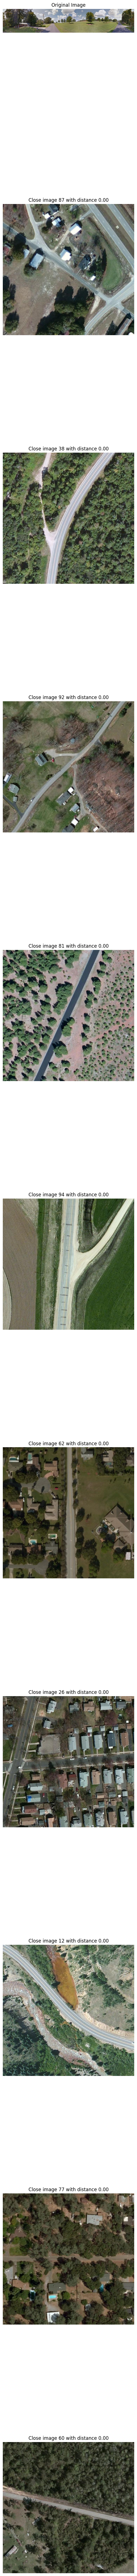

(tensor([[1.1969e-03],
        [1.3840e-04],
        [2.5393e-03],
        [4.6015e-04],
        [1.9463e-03],
        [6.2823e-05],
        [2.7795e-03],
        [9.5844e-04],
        [1.6880e-04],
        [1.0391e-03],
        [1.3185e-03],
        [1.4939e-03],
        [3.7909e-05],
        [7.3421e-04],
        [2.3437e-04],
        [1.7452e-04],
        [1.4312e-03],
        [4.8375e-04],
        [3.5191e-04],
        [2.8980e-04],
        [1.6117e-04],
        [2.3806e-04],
        [1.9646e-04],
        [5.0890e-04],
        [5.0879e-04],
        [3.9029e-04],
        [3.5286e-05],
        [2.6798e-04],
        [5.7578e-05],
        [3.5658e-03],
        [1.9038e-04],
        [1.9848e-04],
        [5.9807e-04],
        [1.6665e-04],
        [8.0585e-05],
        [9.8753e-04],
        [1.4719e-03],
        [1.0836e-04],
        [2.0266e-06],
        [6.8426e-05],
        [1.7201e-03],
        [1.3769e-04],
        [2.4843e-04],
        [2.8193e-04],
        [9.8705e-05],
        [

In [35]:
print(model.search(data_module.dataset[1][0], data_module.dataset[:100][1], 10))

Search

In [34]:
  # def search(self, grd_descriptor, sat_descriptor,topK):

  #       dist_array = 2 - 2 * np.matmul(sat_descriptor.cpu(), np.transpose(grd_descriptor.cpu()))
  #       topk_indices = []

  #       for i in range(dist_array.shape[0]):
  #           gt_dist = dist_array[i, i]
  #           distances = dist_array[i, :]
  #           distances[i] = np.inf  # Escludi la distanza con se stesso

  #           # Trova gli indici delle top-K immagini (con distanze minori di gt_dist)
  #           topk_indices_i = np.argsort(distances)[:topK]
  #           topk_indices.append(topk_indices_i)

  #       return topk_indices

#SIFT APPROACH

##UNIVERSITY

###GROUND

In [ ]:
# Definisci il percorso della cartella contenente le sottocartelle con le immagini
source_dir = "/content/University-Release/train/street"

# Dizionario per contenere le immagini
data = {}

# Itera su tutte le sottocartelle nella cartella di origine
for i, folder_name in enumerate(sorted(os.listdir(source_dir))):
    # Crea il percorso completo della sottocartella
    folder_path = os.path.join(source_dir, folder_name)
    # Se la sottocartella è una cartella
    if os.path.isdir(folder_path):
        # Lista per contenere le immagini della cartella corrente
        folder_images = []
        # Itera su tutti i file all'interno della sottocartella
        for filename in sorted(os.listdir(folder_path)):
            # Crea il percorso completo del file
            file_path = os.path.join(folder_path, filename)
            # Carica l'immagine
            image = cv2.imread(file_path)
            # Aggiungi l'immagine alla lista delle immagini della cartella corrente
            folder_images.append(image)
        # Aggiungi le immagini della cartella al dizionario data
        data[i] = folder_images

# Visualizza il risultato
for folder_id, images in data.items():
    print(f"Folder ID: {folder_id}, Numero di immagini: {len(images)}")




In [ ]:
cv2_imshow(data[0][0])
print(data[1][1].shape)

In [ ]:
images_training = []
for images in data.values():
  for image in images:
    images_training.append(image)
print(len(images_training))




cv2_imshow(images_training[0])

In [ ]:
# convert images to grayscale
bw_images_g = []
for img in tqdm(images_training):
    # if RGB, transform into grayscale
    if len(img.shape) == 3:
        bw_images_g.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        # if grayscale, do not transform
        bw_images_g.append(img)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(bw_images[1], cmap='gray')
plt.show()

In [ ]:
# defining feature extractor that we want to use (SIFT)
extractor = cv2.xfeatures2d.SIFT_create()

# initialize lists where we will store *all* keypoints and descriptors
keypoints = []
descriptors = []

for img in tqdm(bw_images):
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

In [ ]:
print(f"len before: {len(descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(f"len after: {len(descriptors)}")

In [ ]:
output_image = []
for x in range(3):
    output_image.append(cv2.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show()

In [ ]:
# select the same numbers in each run
np.random.seed(0)
# select 1000 random image index values
sample_idx = np.random.randint(0, len(data)+1, 1000).tolist()
len(sample_idx)

In [ ]:
# extract the sample from descriptors
# (we don't need keypoints)
descriptors_sample = []

for n in tqdm(sample_idx):
    descriptors_sample.append(np.array(descriptors[n]))

In [ ]:
all_descriptors = []
# extract image descriptor lists
for img_descriptors in tqdm(descriptors_sample):
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)

In [ ]:
# check the shape
all_descriptors.shape

In [ ]:
# we can count the number of descriptors contained in descriptors to confirm
count = []
for img_descriptors in descriptors_sample:
    count.append(len(img_descriptors))
# here we can see the number of descriptors for the first five images
print(f"first five: {count[:5]}")
# and if we sum them all, we should see the 39893 from before
print(f"count all: {sum(count)}")

In [ ]:
# perform k-means clustering to build the codebook
from scipy.cluster.vq import kmeans

k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters) # It takes approx. 2-3 minutes

In [ ]:
# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in tqdm(descriptors):
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [ ]:
# let's see what the visual words look like for image 0
visual_words[0][:5], len(visual_words[0])

In [ ]:
frequency_vectors = []
for img_visual_words in tqdm(visual_words):
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [ ]:
frequency_vectors.shape

In [ ]:
# we know from above that ids 84, 22, 45, and 172 appear in image 0
for i in [84,  22,  45, 172]:
    print(f"{i}: {frequency_vectors[0][i]}")

In [ ]:
frequency_vectors[0][:20]

In [ ]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

In [ ]:
# N is the number of images, i.e. the size of the dataset
N = 2659

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)

In [ ]:
df.shape, df[:5]

In [ ]:
idf = np.log(N/ df)
idf.shape, idf[:5]

In [ ]:
tfidf = frequency_vectors * idf
tfidf.shape, tfidf[0][:5]

In [ ]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

In [ ]:
search_i = 0

plt.imshow(bw_images[search_i], cmap='gray')
plt.show()

In [ ]:
# cosine similarity
from numpy.linalg import norm

a = tfidf[search_i]
b = tfidf  # set search space to the full sample

cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
print("Min cosine similarity:", round(np.min(cosine_similarity),1))
print("Max cosine similarity:", np.max(cosine_similarity))

In [ ]:
cosine_similarity.shape

In [ ]:
cosine_similarity

In [ ]:
top_k = 5
idx = np.argsort(-cosine_similarity)[:top_k]
idx

In [ ]:
cosine_similarity[idx[0]]

In [ ]:
for i in idx:
    print(f"{i}: {round(cosine_similarity[i], 4)}")
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()

In [ ]:
def search(i: int, top_k: int = 5):
    print("Search image:")
    # show the search image
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()
    print("-----------------------------------------------------")
    # get search image vector
    a = tfidf[i]
    # get the cosine distance for the search image `a`
    cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
    # get the top k indices for most similar vecs
    idx = np.argsort(-cosine_similarity)[:top_k]
    # display the results
    for i in idx:
        print(f"{i}: {round(cosine_similarity[i], 4)}")
        plt.imshow(bw_images[i], cmap='gray')
        plt.show()

In [ ]:
search(121)

In [ ]:
search(3)

In [ ]:
for i in range(3,7):
  cv2_imshow(images_training[i])

In [ ]:
search(1)

### AERIAL

In [ ]:
# Definisci il percorso della cartella contenente le sottocartelle con le immagini
source_dir = "/content/University-Release/train/satellite"

# Dizionario per contenere le immagini
data = {}

# Itera su tutte le sottocartelle nella cartella di origine
for i, folder_name in enumerate(sorted(os.listdir(source_dir))):
    # Crea il percorso completo della sottocartella
    folder_path = os.path.join(source_dir, folder_name)
    # Se la sottocartella è una cartella
    if os.path.isdir(folder_path):
        # Lista per contenere le immagini della cartella corrente
        folder_images = []
        # Itera su tutti i file all'interno della sottocartella
        for filename in sorted(os.listdir(folder_path)):
            # Crea il percorso completo del file
            file_path = os.path.join(folder_path, filename)
            # Carica l'immagine
            image = cv2.imread(file_path)
            # Aggiungi l'immagine alla lista delle immagini della cartella corrente
            folder_images.append(image)
        # Aggiungi le immagini della cartella al dizionario data
        data[i] = folder_images

# Visualizza il risultato
for folder_id, images in data.items():
    print(f"Folder ID: {folder_id}, Numero di immagini: {len(images)}")

In [ ]:
images_training = []
for images in data.values():
  for image in images:
    images_training.append(image)
print(len(images_training))




cv2_imshow(images_training[0])

In [ ]:
import cv2

# convert images to grayscale
bw_images = []
for img in tqdm(images_training):
    # if RGB, transform into grayscale
    if len(img.shape) == 3:
        bw_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        # if grayscale, do not transform
        bw_images.append(img)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(bw_images[1], cmap='gray')
plt.show()

In [ ]:
# defining feature extractor that we want to use (SIFT)
extractor = cv2.xfeatures2d.SIFT_create()

# initialize lists where we will store *all* keypoints and descriptors
keypoints = []
descriptors = []

for img in tqdm(bw_images):
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

In [ ]:
print(f"len before: {len(descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(f"len after: {len(descriptors)}")

In [ ]:
output_image = []
for x in range(3):
    output_image.append(cv2.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show()

In [ ]:
import numpy as np

# select the same numbers in each run
np.random.seed(0)
# select 1000 random image index values
sample_idx = np.random.randint(0, len(data)+1, 50).tolist()
len(sample_idx)

In [ ]:
# extract the sample from descriptors
# (we don't need keypoints)
descriptors_sample = []

for n in tqdm(sample_idx):
    descriptors_sample.append(np.array(descriptors[n]))

In [ ]:
all_descriptors = []
# extract image descriptor lists
for img_descriptors in tqdm(descriptors_sample):
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)

In [ ]:
# check the shape
all_descriptors.shape

In [ ]:
# we can count the number of descriptors contained in descriptors to confirm
count = []
for img_descriptors in descriptors_sample:
    count.append(len(img_descriptors))
# here we can see the number of descriptors for the first five images
print(f"first five: {count[:5]}")
# and if we sum them all, we should see the 39893 from before
print(f"count all: {sum(count)}")

In [ ]:
# perform k-means clustering to build the codebook
from scipy.cluster.vq import kmeans

k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters) # It takes approx. 2-3 minutes

In [ ]:
# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in tqdm(descriptors):
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [ ]:
# let's see what the visual words look like for image 0
visual_words[0][:5], len(visual_words[0])

In [ ]:
frequency_vectors = []
for img_visual_words in tqdm(visual_words):
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [ ]:
frequency_vectors.shape

In [ ]:
# we know from above that ids 84, 22, 45, and 172 appear in image 0
for i in [84,  22,  45, 172]:
    print(f"{i}: {frequency_vectors[0][i]}")

In [ ]:
frequency_vectors[0][:20]

In [ ]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

In [ ]:
# N is the number of images, i.e. the size of the dataset
N = 2659

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)

In [ ]:
df.shape, df[:5]

In [ ]:
idf = np.log(N/ df)
idf.shape, idf[:5]

In [ ]:
tfidf_sat = frequency_vectors * idf
tfidf_sat.shape, tfidf[0][:5]

In [ ]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

In [ ]:
search_i = 0

plt.imshow(bw_images[search_i], cmap='gray')
plt.show()

In [ ]:
# cosine similarity
from numpy.linalg import norm

a_sat = tfidf_sat[search_i]
b_sat = tfidf_sat  # set search space to the full sample

cosine_similarity = np.dot(a_sat, b_sat.T)/(norm(a_sat) * norm(b_sat, axis=1))
print("Min cosine similarity:", round(np.min(cosine_similarity),1))
print("Max cosine similarity:", np.max(cosine_similarity))

In [ ]:
cosine_similarity.shape

In [ ]:
cosine_similarity

In [ ]:
top_k = 5
idx = np.argsort(-cosine_similarity)[:top_k]
idx

In [ ]:
cosine_similarity[idx[0]]

In [ ]:
for i in idx:
    print(f"{i}: {round(cosine_similarity[i], 4)}")
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()

In [ ]:
def search(i: int, top_k: int = 5):
    print("Search image:")
    # show the search image
    plt.imshow(bw_images_g[i], cmap='gray')
    plt.show()
    print("-----------------------------------------------------")
    # get search image vector
    a = tfidf[i]
    # get the cosine distance for the search image `a`
    cosine_similarity = np.dot(a, b_sat.T)/(norm(a) * norm(b_sat, axis=1))
    # get the top k indices for most similar vecs
    idx = np.argsort(-cosine_similarity)[:top_k]
    # display the results
    for i in idx:
        print(f"{i}: {round(cosine_similarity[i], 4)}")
        plt.imshow(bw_images[i], cmap='gray')
        plt.show()

In [ ]:
search(121)

In [ ]:
search(3)

In [ ]:
for i in range(3,7):
  cv2_imshow(images_training[i])

In [ ]:
search(0)

##CVUSA

In [ ]:
!pip install opencv-python

In [ ]:
import cv2
import numpy as np
import os

Creo vettore immagini

In [ ]:
import cv2
import numpy as np


import os
from google.colab.patches import cv2_imshow

# Definisci il percorso delle cartelle delle immagini
aerial_folder = "/content/CVUSA_subset/polarmap/normal"
ground_folder = "/content/CVUSA_subset/streetview"
categories=[]
# Carica le immagini ground
ground_images = []
for filename in sorted(os.listdir(ground_folder)):
        image_path = os.path.join(ground_folder, filename)
        ground_images.append(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
        categories.append("ground")
# Carica le immagini aerial
aerial_images = []
for filename in sorted(os.listdir(aerial_folder)):
        image_path = os.path.join(aerial_folder, filename)
        aerial_images.append(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
        categories.append("aerial")

In [ ]:
cv2_imshow(ground_images[0])

In [ ]:
cv2_imshow(aerial_images[0])

In [ ]:
print(ground_images[0].shape)
print(aerial_images[0].shape)

SIFT

In [ ]:
from tqdm import tqdm
# Inizializza l'oggetto SIFT
sift = cv2.SIFT_create()

# Estrai i descrittori SIFT per tutte le immagini ground e aerial

ground_descriptors = []
kp_ground = []
i=0
for img in tqdm(ground_images, desc='Processing ground images'):
    if(i<1000):
      kp, des = sift.detectAndCompute(img, None)
      ground_descriptors.append(des)
      kp_ground.append(kp)
      del kp,des
    else: break
    i+=1



In [ ]:
aerial_descriptors = []
kp_aerial = []
i=0
for img in tqdm(aerial_images, desc='Processing aerial images'):
    if(i<1000):
      kp, des = sift.detectAndCompute(img, None)
      aerial_descriptors.append(des)
      kp_aerial.append(kp)
      del kp,des
    else: break
    i+=1


In [ ]:
print(f"len before: {len(ground_descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(ground_descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del ground_descriptors[i], kp_ground[i]

print(f"len after: {len(ground_descriptors)}")

In [ ]:
print(f"len before: {len(aerial_descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(aerial_descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del aerial_descriptors[i], kp_aerial[i]

print(f"len after: {len(aerial_descriptors)}")

In [ ]:
all_descriptors = []
descriptors= []
# extract image descriptor lists
for img_descriptors in tqdm(ground_descriptors):
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)

for img_descriptors in tqdm(aerial_descriptors):
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)


# extract image descriptor lists
for img_descriptors in tqdm(ground_descriptors):
    # extract specific descriptors within the image
        descriptors.append(img_descriptors)

for img_descriptors in tqdm(aerial_descriptors):
    # extract specific descriptors within the image
        descriptors.append(img_descriptors)

# convert to single numpy array
all_descriptors = np.stack(all_descriptors)
print(all_descriptors.shape)

In [ ]:
import matplotlib.pyplot as plt

output_image = []
for x in range(3):
    output_image.append(cv2.drawKeypoints(aerial_images[x], kp_aerial[x], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show()

In [ ]:
import os
from scipy.cluster.vq import kmeans
from numpy.linalg import norm
num_clusters = 2
codebook, variance = kmeans(all_descriptors, 200, 1)
# vector quantization
from scipy.cluster.vq import vq
print("shape: ", all_descriptors.shape)
print("shape: ", codebook.shape)
visual_words = []
for img_descriptors in tqdm(descriptors):
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)



In [ ]:
frequency_vectors = []
for img_visual_words in tqdm(visual_words):
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(200)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

# N is the number of images, i.e. the size of the dataset
N = 1998

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)
idf = np.log(N/ df)
tfidf = frequency_vectors * idf

In [ ]:
def search(i: int, category: str, top_k: int = 15):
    print("Search image:")
    # show the search image
    if category == 'ground':
      plt.imshow(ground_images[i], cmap='gray')
      plt.show()
      a = tfidf[i]
    else:
      plt.imshow(aerial_images[i], cmap='gray')
      plt.show()
      a = tfidf[i+1000]
    print("-----------------------------------------------------")
    print(tfidf.shape)


    # Calculate cosine similarity with images of the opposite category
    cosine_similarity = np.dot(a, tfidf.T) / (norm(a) * norm(tfidf, axis=1))

    # Get the top k indices for most similar vectors
    idx = np.argsort(-cosine_similarity)
    idx_filtered=None
    if category == 'ground':
      idx_filtered = idx[idx >= 1000][:top_k]
    else:
      idx_filtered = idx[idx < 1000][:top_k]
    print(idx_filtered)
    # Display the results
    for idx_i in idx_filtered:
        print(f"Similarity with image {idx_i} of category {categories[idx_i]}: {round(cosine_similarity[idx_i], 4)}")
        if category == 'ground':
          plt.imshow(aerial_images[idx_i-1000], cmap='gray')
          plt.show()
        else:
          plt.imshow(ground_images[idx_i], cmap='gray')
          plt.show()


In [ ]:
for i in range(1000):
  print("id: ",i, np.dot(tfidf[i], tfidf[i+1000].T) / (norm(tfidf[i]) * norm(tfidf[i+1000])))

In [ ]:
search(9,'ground')

In [ ]:
import cv2
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

class ImageSimilarityCalculator:
    def __init__(self, aerial_link, ground_link):
        self.aerial_link = aerial_link
        self.ground_link = ground_link
        self.num_clusters = 200
        self.sift = cv2.SIFT_create()

    def load_images(self, folder):
        images = []
        for filename in sorted(os.listdir(folder)):
            image_path = os.path.join(folder, filename)
            images.append(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
        return images

    def process_images(self, images):
        descriptors = []
        keypoints = []
        for img in tqdm(images, desc='Processing images'):
            kp, des = self.sift.detectAndCompute(img, None)
            descriptors.append(des)
            keypoints.append(kp)
        return descriptors, keypoints

    def remove_invalid_descriptors(self, descriptors, keypoints):
        to_drop = []
        for i, img_descriptors in enumerate(descriptors):
            if img_descriptors is None:
                to_drop.append(i)
        for i in sorted(to_drop, reverse=True):
            del descriptors[i], keypoints[i]
        return descriptors, keypoints

    def concatenate_descriptors(self, descriptors):
        all_descriptors = np.concatenate(descriptors, axis=0)
        return all_descriptors

    def visualize_keypoints(self, images, keypoints):
        output_images = []
        for img, kp in zip(images, keypoints):
            output_images.append(cv2.drawKeypoints(img, kp, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
            plt.imshow(output_images[-1], cmap='gray')
            plt.show()

    def calculate_similarity(self, tfidf_descriptors):
        num_ground_images = len(self.ground_images)
        num_aerial_images = len(self.aerial_images)
        for i in range(num_ground_images):
            for j in range(num_aerial_images):
                similarity = cosine_similarity(tfidf_descriptors[i], tfidf_descriptors[j + num_ground_images])
                print(f"Similarity between ground image {i} and aerial image {j}:", similarity)

    def process(self):
        # Load images
        self.ground_images = self.load_images(self.ground_link)
        self.aerial_images = self.load_images(self.aerial_link)

        # Process images
        self.ground_descriptors, self.kp_ground = self.process_images(self.ground_images)
        self.aerial_descriptors, self.kp_aerial = self.process_images(self.aerial_images)

        # Remove invalid descriptors
        self.ground_descriptors, self.kp_ground = self.remove_invalid_descriptors(self.ground_descriptors, self.kp_ground)
        self.aerial_descriptors, self.kp_aerial = self.remove_invalid_descriptors(self.aerial_descriptors, self.kp_aerial)

        # Concatenate descriptors
        all_ground_descriptors = self.concatenate_descriptors(self.ground_descriptors)
        all_aerial_descriptors = self.concatenate_descriptors(self.aerial_descriptors)
        all_descriptors = np.concatenate((all_ground_descriptors, all_aerial_descriptors), axis=0)

        # Visualize keypoints
        self.visualize_keypoints(self.aerial_images[:3], self.kp_aerial[:3])

        # Utilize K-Means for clustering
        kmeans = KMeans(n_clusters=self.num_clusters)
        kmeans.fit(all_descriptors)
        codebook = kmeans.cluster_centers_

        # Calculate cluster labels
        labels = kmeans.predict(all_descriptors)

        # Calculate histograms
        histograms = []
        start_index = 0
        for descriptors, images in [(self.ground_descriptors, self.ground_images), (self.aerial_descriptors, self.aerial_images)]:
            for img in images:
                end_index = start_index + len(self.sift.detectAndCompute(img, None)[1])
                histogram = np.bincount(labels[start_index:end_index], minlength=self.num_clusters)
                histograms.append(histogram)
                start_index = end_index

        # Calculate TF-IDF
        tfidf_transformer = TfidfTransformer()
        tfidf_descriptors = tfidf_transformer.fit_transform(histograms)

        # Calculate similarity
        self.calculate_similarity(tfidf_descriptors)





In [ ]:
aerial_link = "/content/CVUSA_subset/polarmap/normal"
ground_link = "/content/CVUSA_subset/streetview"
similarity_calculator = ImageSimilarityCalculator(aerial_link, ground_link)
similarity_calculator.process()

#Siamese Approach

Create the lists

In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

# Definisci il percorso delle cartelle delle immagini
aerial_folder = "/content/CVUSA_subset/polarmap/normal"
ground_folder = "/content/CVUSA_subset/streetview"
categories=[]

# Carica le immagini ground
ground_images = []
for filename in sorted(os.listdir(ground_folder)):
    image_path = os.path.join(ground_folder, filename)
    img = cv2.imread(image_path)
    resized_img = cv2.resize(img, (256, 256))  # Ridimensiona l'immagine a 64x64
    ground_images.append(resized_img)
    categories.append("ground")

# Carica le immagini aerial
aerial_images = []
for filename in sorted(os.listdir(aerial_folder)):
    image_path = os.path.join(aerial_folder, filename)
    img = cv2.imread(image_path)
    resized_img = cv2.resize(img, (256, 256))  # Ridimensiona l'immagine a 64x64
    aerial_images.append(resized_img)
    categories.append("aerial")


In [ ]:
aerial_images[0]

Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torch.utils.data import random_split
import logging
from collections import OrderedDict

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from torch import optim
from torch.utils.data.distributed import DistributedSampler
from pytorch_lightning.callbacks.progress import RichProgressBar

# Define dataset class
class ImagePairDataset(Dataset):
    def __init__(self, ground_images, aerial_images, transform=None):
        self.ground_images = ground_images
        self.aerial_images = aerial_images
        self.transform = transform

    def __len__(self):
        return len(self.ground_images)

    def __getitem__(self, idx):
        ground_image = self.ground_images[idx]
        aerial_image = self.aerial_images[idx]
        if self.transform:
            ground_image = self.transform(ground_image)
            aerial_image = self.transform(aerial_image)
        return ground_image, aerial_image


# Define Siamese Network
class SiameseNetwork(pl.LightningModule):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Define convolutional layers for feature extraction

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        self.fc1 = nn.Linear(230400, 256)  # Assuming input image size is 64x64

    def forward(self, x): #prima forward_once
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x_flat = torch.flatten(x, 1)  # Appiattisce il tensore, mantenendo la dimensione del batch

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        return x

    # def forward(self, input1, input2):
    #     output1 = self.forward_once(input1)
    #     output2 = self.forward_once(input2)
    #     return output1, output2

class WeightedSoftMarginTripletLoss(pl.LightningModule):
    def __init__(self,ImagePairDataset, loss_weight=10.0):
        super(WeightedSoftMarginTripletLoss, self).__init__()

        self.ImagePairDataset = ImagePairDataset
        # Define the sizes for train, validation, and test sets
        train_size = int(0.7 * len(ImagePairDataset))  # 70% for training

        val_size = int(0.15 * len(ImagePairDataset))   # 15% for validation

        test_size = len(ImagePairDataset) - train_size - val_size  # Remaining for testing

        # Use random_split to split the dataset
        self.datatrain, self.dataval, self.datatest = random_split(ImagePairDataset, [train_size, val_size, test_size])

        self.SiameseNetwork = SiameseNetwork()
        self.loss_weight = loss_weight

    def forward(self, x1, x2):
        grd_global = self.SiameseNetwork.forward(x1)
        sat_global = self.SiameseNetwork.forward(x2)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())

        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix


        return triplet_dist_g2s , triplet_dist_s2g , pair_n ,grd_global, sat_global


    def loss(self,triplet_dist_g2s , triplet_dist_s2g , pair_n ):
        loss_g2s = torch.sum(torch.log(1 + torch.exp(triplet_dist_g2s * self.loss_weight))) / pair_n
        loss_s2g = torch.sum(torch.log(1 + torch.exp(triplet_dist_s2g * self.loss_weight))) / pair_n
        loss = (loss_g2s + loss_s2g) / 2.0

        return loss

    def validate_topk(self, dist_array, topK):
        accuracy = 0.0
        data_amount = 0.0

        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            prediction = np.sum(dist_array[i, :] < gt_dist)
            if prediction < topK:
                accuracy += 1.0
            data_amount += 1.0
        accuracy /= data_amount

        return accuracy

    def validate(self, grd_descriptor, sat_descriptor):
        accuracy = 0.0
        data_amount = 0.0
        dist_array = 2 - 2 * np.matmul(sat_descriptor.cpu(), np.transpose(grd_descriptor.cpu()))

        top1_percent = int(dist_array.shape[0] * 0.01) + 1
        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            prediction = torch.sum(dist_array[:, i].cpu().lt(gt_dist.cpu()))
            if prediction < top1_percent:
                accuracy += 1.0
            data_amount += 1.0
        accuracy /= data_amount

        return accuracy



    def training_step(self, batch, batch_idx):
      grd, sat = batch
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd ,sat)
      loss_val = self.loss(dist_g2s , dist_s2g , pair_n)
      self.log('train_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_val})
      output = {"loss": loss_val, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):
        grd, sat = batch
        dist_g2s, dist_s2g, pair_n, grd_global , sat_global = self.forward(grd, sat)
        loss_val = self.loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validate(grd_global, sat_global)  # Calcola l'accuratezza
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy', accuracy_val, on_step=False, on_epoch=True, prog_bar=True )
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output



    def test_step(self, batch, batch_idx):
        grd, sat = batch
        dist_g2s, dist_s2g, pair_n, grd_global, sat_global = self.forward(grd, sat)
        loss_val = self.loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validate(grd_global, sat_global)  # Calcola l'accuratezza
        self.log('test_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy', accuracy_val, on_step=False, on_epoch=True, prog_bar=True )
        return {"test_loss": loss_val, "test_accuracy": accuracy_val}

    def configure_optimizers(self):
        """
        return whatever optimizers we want here
        :return: list of optimizers
        """
        optimizer = optim.SGD(self.parameters(),
                             lr=0.01, momentum=0.90)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max=10)
        return [optimizer], [scheduler]

    def __dataloader(self, train, dataset):
        # when using multi-node (ddp) we need to add the  datasampler
        train_sampler = None
        batch_size = 80

        should_shuffle = train and train_sampler is None
        loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=should_shuffle,
            sampler=train_sampler,
            num_workers=0,
            drop_last=True
        )

        return loader

    def train_dataloader(self):
        logging.info('training data loader called')
        return self.__dataloader(train=True, dataset=self.datatrain)

    def val_dataloader(self):
        logging.info('val data loader called')
        return self.__dataloader(train=False, dataset=self.dataval)

    def test_dataloader(self):
        logging.info('val data loader called')
        return self.__dataloader(train=False, dataset=self.datatest)



In [ ]:
# Data setup
# Assuming you have ground_images and aerial_images as lists of image paths
# Assuming you have defined appropriate transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# Create a RichProgressBar callback
progress_bar = RichProgressBar()

# Initialize dataset and dataloader
dataset = ImagePairDataset(ground_images, aerial_images, transform=transform)

# Initialize Siamese Network, Triplet Loss, and LightningModule

model = WeightedSoftMarginTripletLoss(dataset)

trainer = Trainer(max_epochs=20 , callbacks=[progress_bar])

trainer.fit(model)


In [ ]:
trainer.test(model)

In [ ]:
!tensorboard --logdir=logs
